### MonthlySVD
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell
- calculate singular value decomposition by grid cell, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import utils
import numpy as np
import pandas as pd
import esmlab

# Try scipy to detrend
import segment as sg
import scipy
from scipy import signal

# some resources for plotting
import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs
%matplotlib inline

In [2]:
## User defined options
model = 'CLM5_GSWP3'
var  = 'GPP'
suff = 'lnd/proc/tseries/month_1/'
path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'+suff
file = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var +'.185001-201412.nc'
file

'/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.GPP.185001-201412.nc'

#### Read in your data

In [3]:
# wrapping the time_set_mid utility corrects time being read in by xr.open_dataset
# data sets have lots of coords, variables, and attributes
ds   = utils.time_set_mid(xr.open_dataset(file, decode_times=True), 'time')
area = ds.area
landfrac = ds.landfrac
da = ds[var]    # strips out the extra coords and variables from the dataset
dataset = da.to_dataset()  # convert the previously created unnamed DataArray to Dataset with a variable named "array"
print(dataset)

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1980)
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * time     (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
Data variables:
    GPP      (time, lat, lon) float32 ...


### Quick look at annual cycle for a grid cell

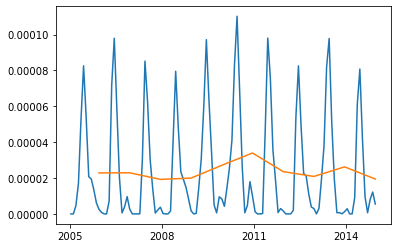

In [4]:
#ds_test = ds.sel(lat=-5, lon=300, method='nearest') #select a single grid point to work with first
ds_test = ds.sel(lat=40, lon=40, method='nearest') #select a single grid point to work with first
# let's just get the last X years of data
years = 10
months = years * 12
ds_last = ds_test.isel(time=slice(-months,None))
da = ds_last[var]    # strips out the extra coords and variables from the dataset
dataset = da.to_dataset()  # convert the previously created unnamed DataArray to Dataset with a variable named "array"
ds_ann  = dataset.apply(utils.weighted_annual_mean)
plt.plot(ds_last.time['time'], ds_last.get(var), '-' );
plt.plot(ds_ann.time['time'], ds_ann.get(var), '-' );

### Calculate climatology and anomalies

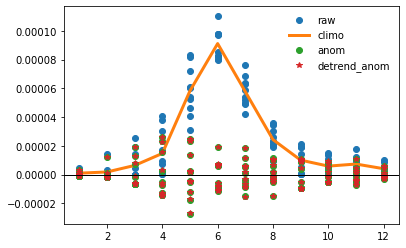

In [5]:
# esmlab anomaly function needs time_bounds in the dataset!
# test to see of climatology and anomaly functions see to work appropriately?
ds_climo = esmlab.core.climatology(ds_last,freq='mon')
ds_anom = esmlab.core.anomaly(ds_last, clim_freq='mon', time_coord_name='time')
ds_detrend = signal.detrend(ds_anom.get(var))
plt.plot(ds_last.time['time.month'], ds_last.get(var), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend, '*' );
plt.legend(labels=('raw','climo','anom','detrend_anom'),frameon = False)
plt.axhline(0, color='black', lw=1);

### Do we need to detrend data?

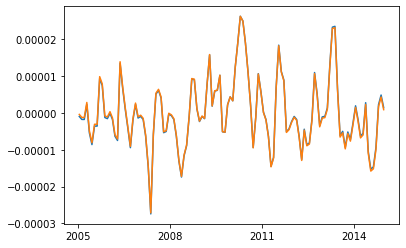

In [6]:
plt.plot(ds_anom.time['time'], ds_anom.get(var), '-' )
plt.plot(ds_anom.time['time'], ds_detrend, '-' );

### Start singular vector decomposition
#### This is from Gretchen's CLM_SVD code 

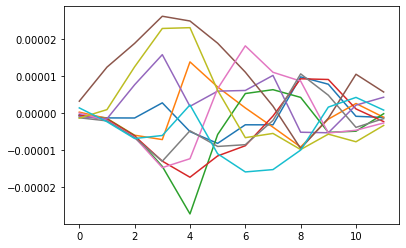

In [7]:
# Reshape month x year
# uniqueyears=np.unique(ds_detrend.time['time.year'])
# iavmatrix=np.zeros([12, len(uniqueyears)])
iavmatrix=np.zeros([12, years])
for iyr in range(years):
    iavmatrix[0:12, iyr]=ds_detrend[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
#print(iavmatrix.shape)
#print(iavmatrix)
#print(ds_anom.get(var)[0:12])

plt.figure();
plt.plot(iavmatrix);

In [8]:
import SVD_tools as svd
monthlimits=np.array([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
DOYlimits=np.cumsum(monthlimits)


In [9]:
U, s, V = np.linalg.svd(iavmatrix, full_matrices=False)
Nyears=iavmatrix.shape[1]
Nmonths=iavmatrix.shape[0]
S = np.diag(s)

# IF Nmonth < Nyears
# Sigma needs to have same dimensions as iavMatrix (12,nyear)
'''We can achieve this by creating a new Sigma matrix of all zero values that is 
   m x n (e.g. more rows) and populate the first n x n part of the matrix with 
   the square diagonal matrix calculated via diag().
   https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
   '''
# create m x n Sigma matrix
Sigma = np.zeros((Nmonths, Nyears))
# populate Sigma with n x n diagonal matrix
# Sigma[:Nmonths, :Nmonths] = np.diag(s)

print('U = ',U.shape)  #(nmonth,nmonth)
print('S = ',S.shape)  #(nmonth,nmonth)
print('s = ',s.shape)  #(nmonth,)
print('V = ',V.shape)  #(nmonth,nyear)
print('Sigma = ',Sigma.shape)
#print(Nyears, Nmonths)
sv_vectors_sif = np.zeros((Nyears,Nmonths),dtype='float')
sv_weights_sif = np.zeros((Nyears,Nyears),dtype='float')
##Here we define the vector shapes by taking the dot product of U and S. 
##0 and 1 refer to the first and second singular vector, respectively
for iyear in range(Nyears):
    sv_vectors_sif[iyear,:]=np.dot(U,S)[:,iyear]
    sv_weights_sif[iyear,:]=V[iyear,:]  
print('sv_vector = ',sv_vectors_sif.shape)
print('sv_weights = ',sv_weights_sif.shape)
            

U =  (12, 10)
S =  (10, 10)
s =  (10,)
V =  (10, 10)
Sigma =  (12, 10)
sv_vector =  (10, 12)
sv_weights =  (10, 10)


In [10]:
#assign the 2-D matrix (year x month) to decompose
## TODO, the decompose functions doesn't like to work with too many years of data?  
[vectors, weights]=svd.decompose(iavmatrix) #Call the function to calculate the singular vectors and their annual weights

[theta,varfrac]=svd.calc_redistribution(vectors, weights, iavmatrix)
varfrac.shape

12 10
[0.69973357 0.56796765 0.28032477 0.82604226 0.00754681 0.06234543
 0.13219817 0.19312888 0.04216031 0.19681049]


(10,)

[ 1.16911422e-06  6.04743897e-06  1.59598263e-05  2.75135900e-05
  2.88215646e-05  1.50630834e-05  3.64890927e-06 -1.22307408e-06
 -1.32204076e-05 -4.14932076e-06  4.17255213e-06  2.85314988e-06]
(10, 12)
(10, 10)


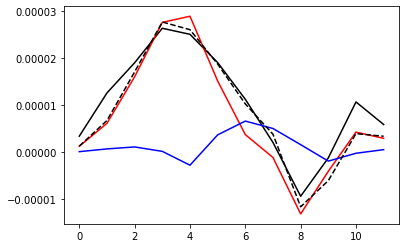

In [11]:
# sanity check make sure that the  first two singular vectors generally reproduce the IAV for a given year
year2check=5
Obs=iavmatrix[:,year2check]
SV1contrib=vectors[0,:]*weights[0,year2check]
SV2contrib=vectors[1,:]*weights[1,year2check]
SV3contrib=vectors[2,:]*weights[2,year2check]
print(SV1contrib)
plt.plot(Obs, 'k-')
plt.plot(SV1contrib, 'r-')
plt.plot(SV2contrib, 'b-')
#plt.plot(SV3contrib, 'g-')
plt.plot(SV1contrib+SV2contrib, 'k--')
print(vectors.shape)
print(weights.shape)
#print(weights)
#plt.figure(3)
#plt.plot(sif_years_anomaly[:,5],'k-',label="Obs")
#plt.plot(sv_vectors_sif[0,:]*sv_weights_sif[0,5],'r-',label="SV1")
#plt.plot(sv_vectors_sif[1,:]*sv_weights_sif[1,5],'b-',label="SV2")
#plt.plot(sv_vectors_sif[0,:]*sv_weights_sif[0,5]+sv_vectors_sif[1,:]*sv_weights_sif[1,5],'k--',label="SV1+2")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2.9826040831455952e-05


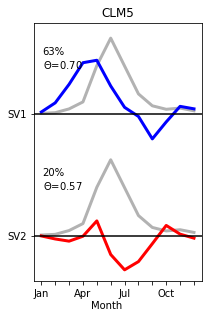

In [12]:
##Plot First and Second Singular Vectors
fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
print(ymax)
vectors2plot=vectors*5000  #This is a totally arbitrary scale factor, decided by me, to make figures look good!
#mm2plot=mm
mm2plot=ds_climo.get(var)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.5,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0]))
ax1.text(0.5,.1,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1]))
ax1.title.set_text('CLM5')
ax1.text(4,-0.29,'Month')
plt.tight_layout()
plt.savefig('SVD_CLM5_ex.eps')


In [13]:
print(weights.shape)

(10, 10)


### Calculate global anomalies

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(120, 192, 288)


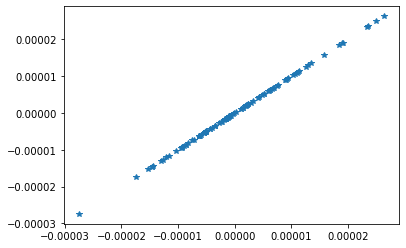

In [14]:
ds2 = ds.isel(time=slice(-months,None))
ds_climo2 = esmlab.core.climatology(ds2,freq='mon')
ds_anom2  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
ds_anom2    
ds_temp = ds_anom2.sel(lat=40, lon=40, method='nearest') #select a single grid point to work with first
plt.plot(ds_temp.get(var), ds_anom.get(var), '*' )
anom_np = ds_anom2.get(var).values # returns a 3d array with dims (time,lat,lon)
print(anom_np.shape)

In [15]:
## define function that wraps in detrending, reshaping, and SVD & returns a np.array
def svd_wrap(anom, years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (year x month) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac


12 10
[0.69973357 0.56796765 0.28032476 0.82604227 0.00754721 0.06234542
 0.13219818 0.1931289  0.04216037 0.19681416]
----
[0.69973357 0.56796765 0.28032476 0.82604227 0.00754721 0.06234542
 0.13219818 0.1931289  0.04216037 0.19681416]
!!!
[0.69973357 0.56796765 0.28032477 0.82604226 0.00754681 0.06234543
 0.13219817 0.19312888 0.04216031 0.19681049]


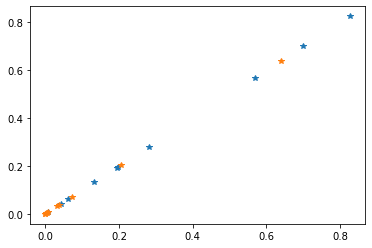

In [16]:
# Make sure results are the same as above

[theta_wrap, varfrac_wrap] = svd_wrap(ds_temp.get(var).values, years)
plt.plot(theta_wrap, theta, '*') ;
plt.plot(varfrac_wrap, varfrac, '*') ;

print('----')
print(theta_wrap)
print('!!!')
print(theta)

In [17]:
print(np.isnan(anom_np[:,50,0])[0])
[theta_wrap, varfrac_wrap] = svd_wrap(anom_np[:,50,0], years)
print(theta_wrap)
print(varfrac_wrap)
print([years,years])

True
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[10, 10]


In [18]:
# Now try this on the full dataset
svd_global = xr.apply_ufunc(svd_wrap, anom_np, years, vectorize=True)

IndexError: invalid index to scalar variable.

In [23]:
# this approach is too slow and sensitive to initial estimate of break point
Y  = ds_anom.get(var)
initialBreakpoints = [[1950],[1960],[1970]]
for i in initialBreakpoints:
    print(i)
    reg = sg.SegmentedLinearReg( decY, Y, i )
    print(reg)
    

[1950]
maximum iteration reached
(array([1850.        , 1945.483377  , 2014.91666667]), array([-1.44856283e-06, -6.67470181e-07,  3.65087234e-06]))
[1960]
maximum iteration reached
(array([1850.        , 1945.53933665, 2014.91666667]), array([-1.44310436e-06, -6.76376590e-07,  3.65602245e-06]))
[1970]
maximum iteration reached
(array([1850.        , 1940.30756364, 2014.91666667]), array([-1.42232938e-06, -7.50705630e-07,  3.56593415e-06]))


#### Make weights for global sum

In [4]:
# would be nice to use cfunits  here
landUp = area * landfrac * 1e6      # area in km2, not m2
orig_units = cf.Unit(landUp.attrs['units'])
target_units = cf.Unit('m^2')
landUp.attrs['units'] = target_units# rename units
area_wgt = landUp / landUp.sum()    # weighting for each grid cell
spy = 365 * 24 * 3600               # Convert  to annual fluxes (gC/m2/y), from gc/m2/s 

#### Convert monthly to annual

In [5]:
# apply iterates through all variables in a dataset and applies the function to each variable.
mean_dataset = dataset.apply(utils.weighted_annual_mean) * spy

#### Calculate global sums

In [6]:
mean_wgt = mean_dataset * landUp
ann_glob = mean_wgt.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
ann_glob.attrs['units'] = 'Pg C y^-1'
print(ann_glob)

<xarray.Dataset>
Dimensions:  (time: 165)
Coordinates:
  * time     (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    GPP      (time) float64 97.99 97.83 97.77 98.42 ... 124.6 121.3 122.3 122.4
Attributes:
    units:    Pg C y^-1


-----------------------------
### Make a line plot

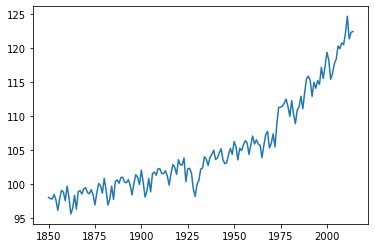

In [7]:
#quick plot , the `;` on the last line supresses text after executing the cell
plt.plot(ann_glob.coords['time.year'], ann_glob[var], '-' );


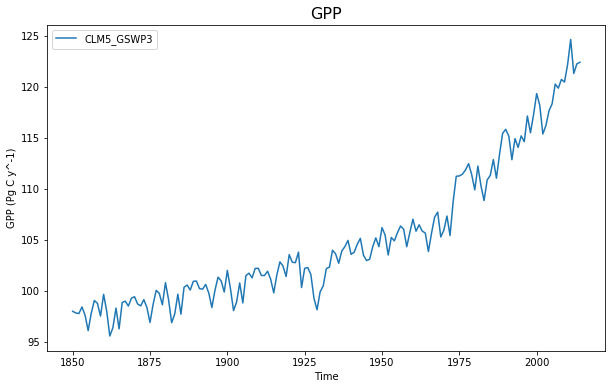

In [8]:
# Create a nicer figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob.coords['time.year'], ann_glob[var], label=model)
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel(var+' (' + ann_glob.attrs['units'] +')')
ax.set_title(var, fontdict={'size':16})
ax.legend(loc='upper left');

------------------------
### Now make a map!

In [41]:
# making a data array, because cyclic_dataarray currently set up that way
x1= mean_dataset.isel(time=slice(0,10)).mean('time')[var] # Climatology for first 10 years of data
x = mean_dataset.isel(time=slice(-10,None)).mean('time')[var] # Climatology for last 10 years of data
x1= utils.cyclic_dataarray(x1)
x = utils.cyclic_dataarray(x)
lat = x.coords['lat']
lon = x.coords['lon']
x

<xarray.DataArray (lat: 192, lon: 289)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 356.25 357.5 358.75 360.0

### Try making a map

<Figure size 720x504 with 0 Axes>

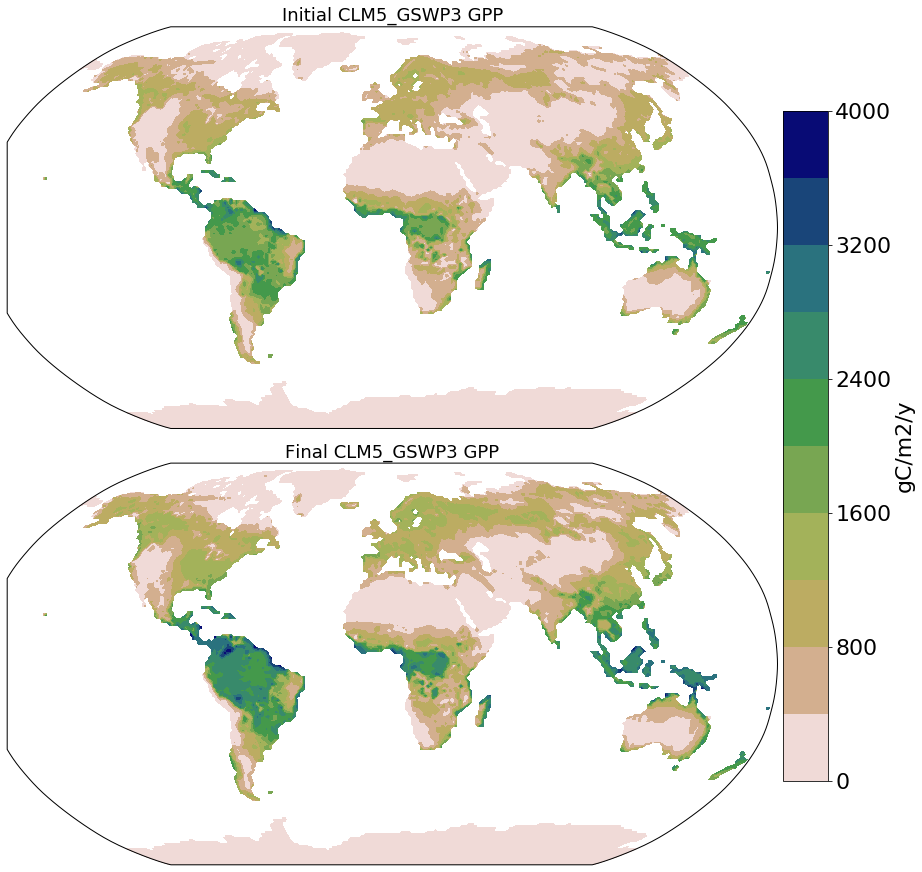

In [48]:
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

norm = colors.Normalize(vmin=0., vmax=4.e3)
norm(x.mean())
# modified from https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
crs = ccrs.Robinson()#central_longitude=305.0)
# Function used to create the map subplots
def plot_background(ax):
    #ax.set_global()
    #ax.coastlines()
    #ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

levels = np.linspace(0, 4000, 11)
fig = plt.figure(figsize=(10, 7),constrained_layout=True)
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(20, 12), constrained_layout=True,
                          subplot_kw={'projection': crs})

axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)

# upper plot
cf0 = axlist[0].contourf(lon, lat, x1, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[0].set_title('Initial '+model+' '+var, fontsize=18)
axlist[0].set_axis_off()

# upper plot
cf1 = axlist[1].contourf(lon, lat, x, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[1].set_title('Final '+model+' '+var, fontsize=18)
axlist[1].set_axis_off()

# add common colorbar
cbar = fig.colorbar(cf1, ax=axlist.ravel().tolist(), 
                    orientation='vertical', shrink=0.80, pad=0)
cbar.set_label('gC/m2/y', size=22)
cbar.ax.tick_params(labelsize=22) 


In [55]:
x.mean()

<xarray.DataArray ()>
array(4139.958175)

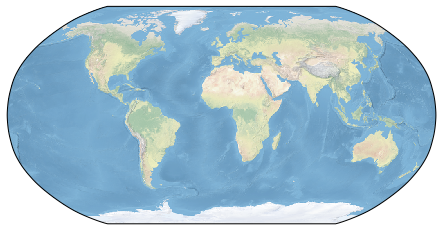

In [37]:
# Works with matplotlib's built-in transform support.
fig = plt.figure(figsize=(10, 4))
ax  = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Sets the extent to cover the whole globe
ax.set_global()

# Adds standard background map
ax.stock_img()


In [35]:
%output holomap='scrubber' fps=3
ann_glob.hvplot(x='lon', y='lat', 
              projection=ccrs.Robinson(central_longitude=0), 
              cmap='Magma')\
       .redim.range(GPP=(0, 100))


DataError: Supplied data does not contain specified dimensions, the following dimensions were not found: ['lon', 'lat']

PandasInterface expects tabular data, for more information on supported datatypes see http://holoviews.org/user_guide/Tabular_Datasets.html

In [20]:
ds2   = utils.time_set_mid(xr.open_dataset(file, decode_times=False), 'time')
ds2

<xarray.Dataset>
Dimensions:       (hist_interval: 2, lat: 192, levdcmp: 25, levgrnd: 25, levlak: 10, lon: 288, time: 1980)
Coordinates:
  * lat           (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.325 44.775
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.25 357.5 358.75
  * time          (time) float64 15.49 45.0 74.5 ... 6.018e+04 6.021e+04
Dimensions without coordinates: hist_interval
Data variables:
    BSW           (levgrnd, lat, lon) float32 ...
    DZLAKE        (levlak, lat, lon) float32 ...
    DZSOI         (levgrnd, lat, lon) float32 ...
    GPP           (time, lat, lon) float32 ...
    HKSAT         (levgrnd, lat, lon) float32 ...
    SUCSAT        (levgrnd, lat, lon) float32 ...
    WATSAT        (levgrnd, lat, lon) float3

In [21]:
ds_ann = esmlab.resample(ds2, freq='ann')
ds_ann

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'CFTimeIndex'